# COVID 19 - Compartmental Model Simulation

<img src="COVIDbanner.png" width="1000"> 

## Introduction

The notebook introduces the compartmental stochastic model developed by [Gareth et al. 2011](https://arxiv.org/abs/1108.3137v1). The COVID-19 model is using Bayesian methods to jointly estimate information from a stochastic mixing matrix that quantifies sexual interaction patterns by age and gender with parameters from a system of high-dimensional ODEs. This stochastic mixing matrix relies on quantities that are a priori unknown. 

The aims of our research is to evaluate the model under new conditions and also improve its inference time.

1. Explore the performance of the model under COVID-19 conditions
2. Improve the calibration time of the model by utilising Stochastic Approximate Inference Methods [Damianou et al.](https://arxiv.org/pdf/1409.2287.pdf).
3. Expand the model capacity by incorporating social mixing matrix methods, such as from POLYMOD and BBC Science [Diekmann et al.](https://royalsocietypublishing.org/doi/10.1098/rsif.2009.0386)

<img src="COVIDb.png" width="1000"> 

From the graph above, we define the following compartments:
- **$S$** is individuals who are at risks of Covid-19 infection
- **$I$** is infected individuals including asymptomatic and mild cases
- **$G$** is infected people who developed more severe cases of symptoms and required hospitalization
- **$P$** is those who recovered, and are seropositive and immune
- **$N$** is individuals who are recovered, immune but seronegative

We also introduce the attributes age ($a$), gender ($g$) and social activity group ($s$) differentiating individuals in a population.

- $a$ : age - is 5-year band
- $g$ : gender - male = 0, female = 1
- $s$ : social intereaction category - active = 1, not active = 0

## Epidimiological Models and the $\mathcal{R}_{0}$

Before we move to present the COVID model it is important to familiarise the reader with the various components that are used in the construction of an epidimiological model. The basic reproduction number $\mathcal{R}_{0}$ is a vital element in order to understand the spread of a disease. Often confused as the rate of spread, $\mathcal{R}_{0}$ is a non-dimensional number that quantifies the average number of secondary infenctions introduced by an individual when he comes into contact with a susceptible population. 

Therefore, $\mathcal{R}_{0}$ gives a summary of the model and illustrates the severity of the decease. The mathematical form of $\mathcal{R}_{0}$ is nicely depicted in [Prof. James Holland Jones](https://web.stanford.edu/~jhj1/teachingdocs/Jones-on-R0.pdf)
 notes.
 
\begin{equation*}
\mathcal{R}_{0}= \bigg(\frac{\mbox{ infection}}{\mbox{ contact}}\bigg) \bigg(\frac{\mbox{ contact}}{\mbox{ time}}\bigg) \bigg(\frac{\mbox{ time}}{\mbox{ infection}}\bigg) 
\end{equation*}

alternatively

\begin{equation}
\mathcal{R}_{0}= \tau \bar{c} d
\end{equation}

with $\tau$ is the probability of transmission during a contact, $\bar{c}$ is the **average** rate of contact between individuals and $d$ is the duration of the infectiousness. Mapping these to a simple SIR model

\begin{align*}
\dot{S} & =  - \beta \frac{SI}{N} \\
\dot{I}  & =  \beta \frac{SI}{N} - \gamma I  \\
\dot{R}  & =  \gamma I 
\end{align*}

$\beta=\tau \bar{c}$, the effective contact rate (force of infection) equals the product of probability of transmission with the average rate of contacts between the population groups.  Also, $d=\gamma^{-1}$, the duration of the infectiousness is the inverse removal rate. Therefore, for an epidemic to spread intuitively needs the infection rate to be $I>0$

\begin{align*}
\beta \frac{SI}{N} - \gamma I  & >  0 \\
\beta \frac{SI}{N}  & >  \gamma I  \\
\mathcal{R}_{0} =  \frac{\beta}{\gamma } & >  0 
\end{align*}

Overall, what we are trying to achieve by calculating the $\mathcal{R}_{0} $ is to create a value that summarises the number of newly infected by averaging the number new infections over all possible infected types. For complex systems (SEIR) a way to compute this number is by utilising matrix algebra. Specifically, to find the average value we can use the spectral radius (dominant eigenvalue) of the NGM, which is similar to the geometric mean. 


## Social Mixing Matrix

jIn the epidimiological research, one of the most challening components is for the scientists to accurately map the social interactions between the infected and the susceptible population. A detailed map can increase the predictive power of the epidemic model as well as its robustness. There are various ways to achieve this task, scientists can rely on past findings and use them as prior in their model, they can focus in local areas or specific countries that a similar research has been conducted, they can model the social interactions using graphical models and census data or they can fund large-scale surveys across countries. From all the methods, the last one is the most accurate but also the most costly and logistically demanding. 

These surveys also have their downside. They usually suffer from sampling bias, also the accuracy depends heavily on the engangement of the user, often is difficult to create common measurements across different countries, a survey of this magnitude takes a long time and they are quite sparse. For example, POLYMOD is a large survey ($n=7,290$) across 8 European countries that has been the scientific standard to build epidimiological models since 2007-2008 when it was ran. POLYMOD shows population bias on children and young adult ages as the focus of the study has been set deliberately on these age groups. Another, similar survey is the most recent (2017-2018) BBC Pandemic; a UK focused survey with $n=38,000$ volunteers between 13-90+ listed by contact type (physical, conversational) and by social environment (work, home, etc).

To construct these social mixing matrices we follow the methodology as described by [Fumanelli et al. 2012](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002673) and we apply them to the BBC Pandemic survey (2018). 

We start with the simple contact matrix $D$ that shows the frequency of contacts that individuals of the age group $j$ have with people from the age group $i$. In the survey, $j$ are also the respodents, the people who reported these contacts. For each individual $k$ of age $j$, we ask to report their daily contacts with age group $i$ and also the location. For instance, the total number of individuals of age $j$ that work in an office is $n_{j}$ and they reported total contacts of age group $i$ for the past 24h $t_{i}$. Then, we average the total number of reported contacts $t_{i}$ by the total number of participants $n_{j}$ and we get the population contact matrix $M=\frac{t_{i}}{n_{j}}$ for each location. Then, we scale the population matrix $M$ by a population factor $w$ for each age group


\begin{equation*}
c_{i,j} = \frac{1}{2}(m_{ij} + m_{j,i}\frac{w_{i}}{w_{j}})
\end{equation*}

This formula gives us the reciprocal matrix $C$. At this stage, the contact matrices are split by location (home, work, public, school) and gender (male, female). For our example, we will create a linear combination of the location matrices and we will scale them by a mobility factor extracted from Google and Apple mobility reports. The new scaled matrix $C$ will be time dependent as mobility changes based on social restriction each country imposes. 


\begin{equation}
\dot{C} = H_{mob}C^{h} + W_{mob}C^{w} + S_{mob}C^{s} + R_{mob}C^{r}
\end{equation}

The SIR model from before, with a social mixing component will take the form

\begin{align*}
\dot{S} & =  - \beta \dot{C} \frac{SI}{N} \\
\dot{I}  & =  \beta \dot{C} \frac{SI}{N} - \gamma I  \\
\dot{R}  & =  \gamma I 
\end{align*}


In [7]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import scipy.linalg as la
import matplotlib.pyplot as plt

register_matplotlib_converters()

class social_interaction_matrix():
    """Initialise the Social Mixing Matrix
    
    Social Mixing Matrices have famously been studied by [Diekmann at al., 2010]. They have 
    been used in many epidemic modelling papers [Klepac et al., 2020; Fumanelli et al., 2012]. 
    In this script we use the most recent BBC Pandemic social mixing matrix [Klepac et al., 2020]
    and the academic standard POLYMOD [Massong et al., 2008]. We also utilise mobility reports from
    Google and Apple in order to construct temporal social mixing matrices that show the effect of
    nationwide lockdowns. 
    
    
    Files:
        POLYMOD data (UK)
        BBC Pandemic data
        Google Mobility Report (UK)
        Apple Mobility Report (UK)
    Input:
        survey: The type of survey POLYMOD or BBC; default=BBC
        location: The area of the contact WORK, SCHOOL, HOME, OTHER; default=["SCHOOL", "WORK", "HOME", "OTHER"]
        time_length: The length of the lockdown measures in days; default=10
        provider: The provider of the mobility data; default=Google
    Output:
        Social Mixing Matrix or an array of Social Mixing Matrices listed by time.
        
    """
    
    def __init__(self, 
                 survey="BBC", 
                 location=["SCHOOL", "WORK", "HOME", "OTHER"]):
        self.survey = survey
        self.location = [x.upper() for x in location]
        
        
    def fill_nan_values(self, matrix):
        diag = np.diagonal(matrix)
        diag = np.nan_to_num(diag, nan=np.nanmean(diag))
        np.fill_diagonal(matrix.values, diag)
        matrix.fillna(matrix.mean(axis=1), inplace=True)
        return(matrix)
    
    def return_ages(self):
        if self.survey == "BBC":
            file = self.location[0]
            df = pd.read_csv("Data/BBC/" + file + ".csv", index_col=0)
            ages = df.columns
        return(ages)
        
    def create_constant_matrix(self):
        if self.survey == "BBC":
            for loc in self.location:
                if loc=="SCHOOL":
                    C_SCHOOL = pd.read_csv("Data/BBC/SCHOOL.csv", index_col=0)
                    C_SCHOOL = self.fill_nan_values(C_SCHOOL)
                elif loc=="WORK":
                    C_WORK = pd.read_csv("Data/BBC/WORK.csv", index_col=0)
                    C_WORK = self.fill_nan_values(C_WORK)
                elif loc=="HOME":
                    C_HOME = pd.read_csv("Data/BBC/HOME.csv", index_col=0)
                    C_HOME = self.fill_nan_values(C_HOME)
                elif loc=="OTHER":
                    C_OTHER = pd.read_csv("Data/BBC/OTHER.csv", index_col=0)
                    C_OTHER = self.fill_nan_values(C_OTHER)            
            C = C_SCHOOL + C_WORK + C_WORK + C_OTHER  
            
        elif self.survey == "POLYMOD":
            for loc in self.location:
                "TBD"        
        return(C)
 

    def create_temporal_matrix(self, time_length=10, provider="Google"):  
        print("In temporal setting we do not include SCHOOLS since under lockdown" +
             " they are completely shut.")
        if provider=="Google":
            Mobility_data = pd.read_csv("Data/Google/MOBILITY.csv")
        else:
            Mobility_data = pd.read_csv("Data/Apple/MOBILITY.csv")
            "TBD"
            
        if self.survey == "BBC":
            for loc in self.location:
                if loc=="WORK":
                    C_WORK = pd.read_csv("Data/BBC/WORK.csv", index_col=0)
                    C_WORK = self.fill_nan_values(C_WORK)
                    mob_data = Mobility_data[Mobility_data.category=="WORK"]
                    mob_data = mob_data.iloc[:, 1:]
                    matrix_temporal_list = []
                    for t in range(time_length):
                        W = np.diag(np.full(C_WORK.shape[1], mob_data.iloc[:, t]))
                        weighted_C = np.matmul(W, C_WORK.values)
                        matrix_temporal_list.append(weighted_C)
                    C_WORK = np.array(matrix_temporal_list)                      
                elif loc=="HOME":
                    C_HOME = pd.read_csv("Data/BBC/HOME.csv", index_col=0)
                    C_HOME = self.fill_nan_values(C_HOME)
                    mob_data = Mobility_data[Mobility_data.category=="HOME"]
                    mob_data = mob_data.iloc[:, 1:]
                    matrix_temporal_list = []
                    for t in range(time_length):
                        W = np.diag(np.full(C_HOME.shape[1], mob_data.iloc[:, t]))
                        weighted_C = np.matmul(W, C_HOME.values)
                        matrix_temporal_list.append(weighted_C)
                    C_HOME = np.array(matrix_temporal_list)
                elif loc=="OTHER":
                    C_OTHER = pd.read_csv("Data/BBC/HOME.csv", index_col=0)
                    C_OTHER = self.fill_nan_values(C_OTHER)
                    mob_data = Mobility_data[Mobility_data.category=="OTHER"]
                    mob_data = mob_data.iloc[:, 1:]
                    matrix_temporal_list = []
                    for t in range(time_length):
                        W = np.diag(np.full(C_OTHER.shape[1], mob_data.iloc[:, t]))
                        weighted_C = np.matmul(W, C_OTHER.values)
                        matrix_temporal_list.append(weighted_C)
                    C_OTHER = np.array(matrix_temporal_list)           
            # Schools in a lockdown are closed, therefore a mobility matrix makes no sense
            C = C_WORK + C_HOME + C_OTHER
        
        elif self.survey == "POLYMOD":
            for loc in self.location:
                "TBD"       
        return(C)  
    
    def plot(self, loc="None"):
            ### To improve it ####
            ### Add more plot options ###
            df = sim.create_constant_matrix()
            eigvals, eigvecs = la.eig(df)
            evals = pd.DataFrame({"y":eigvals.real, "x":df.index})   
            df2 = pd.read_csv("Data/Google/MOBILITY.csv")
            df2=df2.T
            new_header = df2.iloc[0] 
            df2 = df2[1:] 
            df2.columns = new_header 
            df2_melt = pd.melt(df2.reset_index(), id_vars='index')
            df2_melt["value"] = df2_melt["value"].astype("float")
            df2_melt["index"] = pd.to_datetime(df2_melt["index"], format='%d/%m/%Y')
            

            fig3 = plt.figure(constrained_layout=True, figsize=(17,12))
            gs = fig3.add_gridspec(2, 2)
            f3_ax1 = fig3.add_subplot(gs[0, 0])
            f3_ax2 = fig3.add_subplot(gs[0, 1])
            f3_ax3 = fig3.add_subplot(gs[1, :])
            

            sns.heatmap(df, cmap= 'coolwarm', annot = True,  cbar=False, ax=f3_ax1)
            sns.barplot(x="x", y="y", data=evals, ax=f3_ax2)
            sns.lineplot(y="value", x="index", hue="category", data=df2_melt, ax=f3_ax3)
            



## Next Generation Matrix

NGMs are a vital part of the Social Mixing Matrix construction and utilisation process. Many papers that have used SMMs, one way or the other, they had to transform their initial population interaction matrix to be NGM compliant in order to adequately compute the $\mathcal{R}_{0}$. In other words, NGMs show the number of novel infections from each category (age groups, gender groups, etc) in consecutive generations. From the NGM, we can map the $\mathcal{R}_{0}$ to the dominant eigenvalue of the matrix. Overall, what we are trying to achieve by calculating the $\mathcal{R}_{0} $ is to create a value that summarises the number of newly infected by averaging the number new infections over all possible infected types. For complex systems (SEIR) a way to compute this number is by utilising matrix algebra. To find the average value we can use the spectral radius (dominant eigenvalue) of the NGM, which is similar to the geometric mean. 

As an example, we use a SEIR model with 2 exposed categories as an example ($E_{1}, E_{2}$).

\begin{align*}
\dot{S} & =  \mu N - \beta\frac{SI}{N} + \mu S \\
\dot{E}_{1}  & =  \rho \beta \frac{SI}{N} - (\nu_{1} + \mu)\dot{E}_{1} \\
\dot{E}_{2}  & =  (1 - \rho) \beta \frac{SI}{N} - (\nu_{2} + \mu)\dot{E}_{2}\\
\dot{I}  & =  \nu_{1} \dot{E}_{1}  + \\nu_{2} \dot{E}_{2}  - (\gamma + \mu) I \\
\dot{R}  & =  \gamma I - \mu R\\
\end{align*}

where $\mu$ per capita birth and death rates, $\beta$ the transmission rate, $\nu_{i}\in\{1, 2\}$ the rates of leaving the respective latency states $E_{i}$, $\gamma$ the rate of leaving the infection state and $N=S + E_{1} + E_{2} + I + R$.
Let $\dot{x} = (E_{1}, E_{2}, I)^{T}$, and we want to decompose the system to have the form

\begin{equation}
\dot{x} = (T + \Sigma)x
\end{equation} 

where matrix $T$ corresponds to transmissions and matrix $\Sigma$ to transitions. 

The role of $T$ and $\Sigma$ is similar to the sufficient statistics, as all information that is required is included in the decomposition. For the transmission matrix $T$, we create a matrix with infected states, using indices $i, j\in {1, 2, 3}$ and the record $T_{ij}$ is the rate of infection term; individuals from state $j$ infects individuals in $i$. If the element in $T_{ij}$ is 0, then there is no chance of transmission.  Therefore, 

\begin{equation*}
T=
\begin{pmatrix}
0 & 0 & \rho \beta\\
0 & 0 & c (1-\rho)\beta\\
0 & 0 & 0
\end{pmatrix}
\end{equation*}

and 

\begin{equation*}
\Sigma=
\begin{pmatrix}
-(\nu_{1}+\mu) & 0 & 0\\
0 & -(\nu_{2}+\mu) & 0\\
\nu_{1} &  \nu_{2}& -(\gamma + \mu)
\end{pmatrix}
\end{equation*}

hence we solve for the NGM with large domain ($K_{L}$)

\begin{equation*}
K_{L} = -T\Sigma^{-1} = 
\begin{pmatrix}
0 & 0 & \rho \beta\\
0 & 0 & c (1-\rho)\beta\\
0 & 0 & 0
\end{pmatrix}
\times
\begin{pmatrix}
-(\nu_{1}+\mu) & 0 & 0\\
0 & -(\nu_{2}+\mu) & 0\\
\nu_{1} &  \nu_{2}& -(\gamma + \mu)
\end{pmatrix}
\end{equation*}

the dominant eigenvalue of this matrix $K_{L}$ is the $\mathcal{R}_{0}$

\begin{equation}
\mathcal{R}_{0} = \bigg( \frac{\rho \nu_{1}}{\nu_{1} + \mu} + \frac{(1-\rho) \nu_{2}}{\nu_{2} + \mu}  \bigg) \frac{\beta}{(\gamma + \mu)}
\end{equation}

or similarly, by using the equation of NGM

\begin{equation}
K=E^{T}K_{L}E=-E^{T}T\Sigma^{-1}E
\end{equation}

with $E$ being a matrix that its columns contain unit vectors the non-zero rows of matrix $T$, which leads

\begin{equation}
\mathcal{R}_{0}  = \rho (K) = \frac{1}{2} \bigg( trace(K) + \sqrt{trace(K)^{2} + 4det(K)} \bigg)
\end{equation}

The above case can be expanded for two groupings of individuals (male and female). 

## Connect $\mathcal{R}_{0}$, Social Mixing Matrices and Next Generation Matrix

From the above, we can now connect the social mixing matrices with $\mathcal{R}_{0}$ in a simple SIR model

\begin{equation}
\mathcal{R}_{0}  \approx \rho (\beta \gamma^{-1} \dot{C}) 
\end{equation}

which is the spectral radius of the social mixing matrix. From [Klepac et al. 2020](https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2) we can infer the connection with the NGM matrix 

\begin{equation}
NGM  = \frac{\mathcal{R}_{0}}{\rho(\dot{C})} \dot{C}
\end{equation}



## Code

### Initialise the Temporal Social Mixing Matrix

\begin{equation}
\dot{C} = H_{mob}C^{h} + W_{mob}C^{w} + S_{mob}C^{s} + R_{mob}C^{r}
\end{equation}

In temporal setting we do not include SCHOOLS since under lockdown they are completely shut.


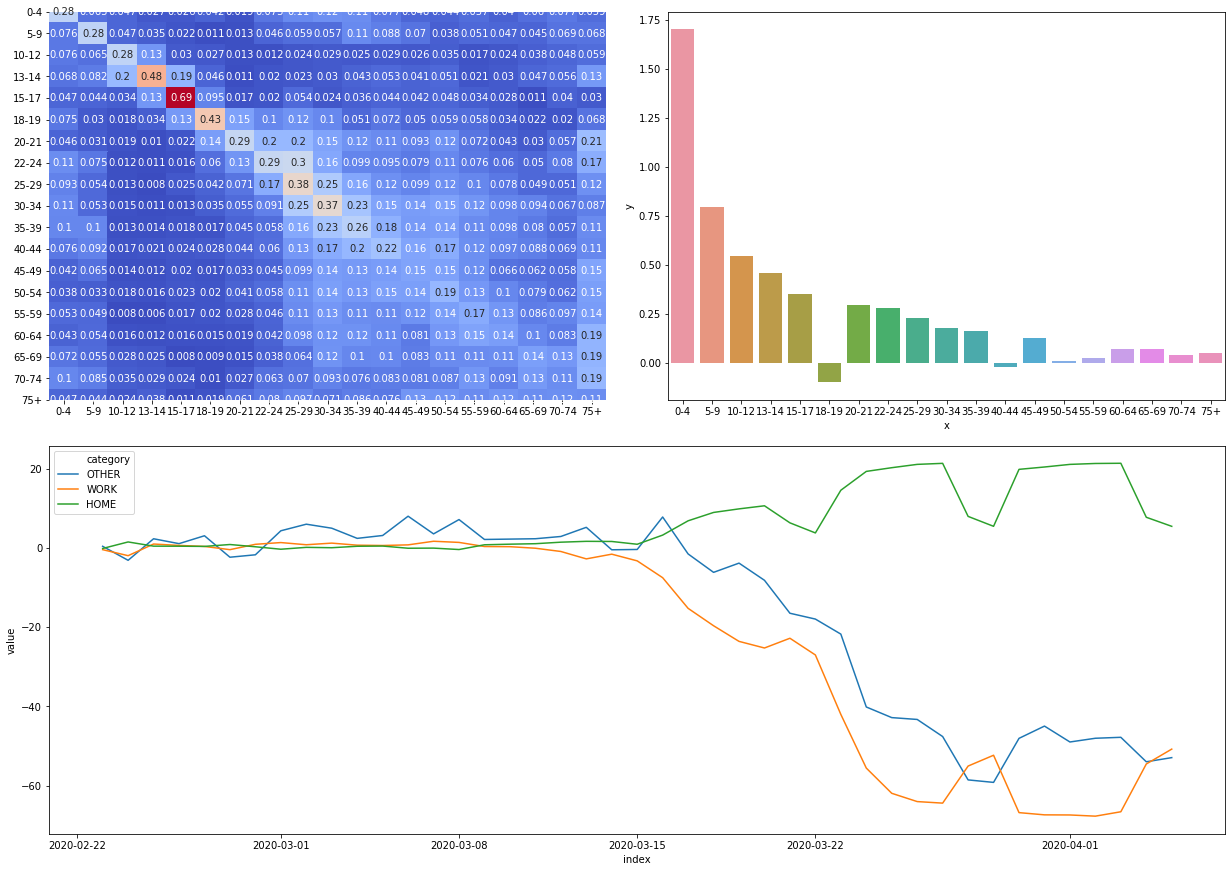

In [8]:
sim = social_interaction_matrix(survey="BBC", location=["SCHOOL", "WORK", "HOME", "OTHER"])
C = sim.create_temporal_matrix()
sim.plot()

In [30]:
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors
np.random.seed(123)

np.concat = np.concatenate

STATES = ['S', 'I', 'G', 'P', 'N']

A_CATEGORIES = sim.return_ages()

In [4]:
ages

array([  0,  25,  50,  75, 100], dtype=int32)

Based on the mixing matrix we derive the force of infection $\lambda$

\begin{equation}
\lambda_{g,s,a}=\beta_{g}\sum_{s^{'}, \alpha^{'}} \bigg\{ c^{*}_{g,s,s^{'},\alpha,\alpha^{'}} \frac{I_{g^{'}, s^{'}, \alpha{'}}}{S_{g^{'}, s^{'}, \alpha{'}} + I_{g^{'}, s^{'}, \alpha{'}} + G_{g^{'}, s^{'}, \alpha{'}} + P_{g^{'}, s^{'}, \alpha{'}} + N_{g^{'}, s^{'}, \alpha{'}} } \bigg\}
\end{equation}

In [155]:
def _intensity_np(t, a, S, I, G, P, N, C):
    left, right = I, (S + I + G + P + N)
    opposite_group_ratio = np.divide(left, right, out=np.zeros_like(left), where=right!=0)
    infectious_interactions = np.sum(C[t, a,:] * opposite_group_ratio)
    return infectious_interactions
    
def _intensity_tf(t, a, S, I, G, P, N, C):
    opposite_group_ratio = tf.math.divide_no_nan(I, (S + I + G + P + N))
    infectious_interactions = tf.reduce_sum(C[t, a,:] * opposite_group_ratio)
    return infectious_interactions
    
# Force of infection lambda
def intensity(framework, *args):
    if framework == np:
        return _intensity_np(*args)
    elif framework == tf:
        return _intensity_tf(*args)

The script below describes the ODEs

\begin{align*}
\tag{1}
& \dot{S}_{g,s,a} & = & -\lambda_{g,s,a}(t)S_{g,s,a} + (P_{g,s,a} + N_{g,s,a})/DI_g + \frac{1}{r}S_{g,s,a-1} - \frac{1}{r}S_{g,s,a} + &\\
&&& \frac{1}{R}\sum_{g,s}(S_{g,s,20} + I_{g,s,20} + G_{g,s,20} + P_{g,s,20} + N_{g,s,20}) \times &\\
&&& \delta_1(a)(\pi_1\delta_1(s) + \pi_2\delta_2(s) + \pi_3\delta_3(s) + \pi_4\delta_4(s)) &\\ \\
\tag{2}
& \dot{I}_{g,s,a}  & = &  \lambda_{g,s,a}(t)S_{g,s,a} - (1/WIP_g + 1/DAI_g)I_{g,s,a} + \frac{1}{r}I_{g,s,a-1}-\frac{1}{r}I_{g,s,a} &\\ \\
\tag{3}
& \dot{G}_{g,s,a}  & = &  I_{g,s,a}/WIP_g - G_{g,s,a}/DWT_g + \frac{1}{r}G_{g,s,a-1} - \frac{1}{r}G_{g,s,a} &\\ \\ 
\tag{4}
& \dot{P}_{g,s,a}  & = &  PSC_g(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - P_{g,s,a}/DI_g + \frac{1}{r}P_{g,s,a-1} - \frac{1}{r}P_{g,s,a} &\\ \\
\tag{5}
& \dot{N}_{g,s,a}  & = &  (1-PSC_g)(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - N_{g,s,a}/DI_g + \frac{1}{r}N_{g,s,a-1}-\frac{1}{r}N_{g,s,a} &\\ \\
\end{align*}

$r = 5 * 365 = 1825$

$R = 2 * 2 * 1825 = 7300$

In [32]:
def dS(t, a, S=None, I=None, G=None, P=None, N=None, C=None, di=None, sip=None, r=None, framework=np, **kwargs):
    dSdt = - intensity(framework, t, a, S, I, G, P, N, C) * S[a] + \
        (P[a] + N[a]) / di[g] - S[a] / r + int(bool(a)) * S[a-1] / r
    
    if a != 0:
        return dSdt
        
    sum_func = tf.reduce_sum if framework == tf else np.sum
        
    R = 4
    inflow = sum_func(
        sum_func([
            S[:,-1], 
            I[:,-1],
            G[:,-1],
            P[:,-1],
            N[:,-1]
        ]) * sip / r
    )
            
    return dSdt + inflow / R

def dI(t, a, S=None, I=None, G=None, P=None, N=None, C=None, wip=None, dai=None, r=None, framework=np, **kwargs):
    dIdt = intensity(framework, t, a, S, I, G, P, N, C) * S[a] - \
        (1/wip[g] + 1/dai[g]) * I[a] - I[a] / r + int(bool(a)) * I[a-1] / r
    
    return dIdt

def dG(t, a, I=None, G=None, wip=None, dwt=None, r=None, **kwargs):
    dGdt = I[a] / wip[g] - G[a] / dwt[g] - G[a] / r + int(bool(a)) * G[a-1] / r
    
    return dGdt

def dP(t, a, I=None, G=None, P=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dPdt = psc[g] * (I[a] / dai[g] + G[a] / dwt[g]) - P[a] / di[g] - \
        P[a] / r + int(bool(a)) * P[a-1] / r
    
    return dPdt

def dN(t, a, I=None, G=None, N=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dNdt = (1-psc[g]) * (I[a] / dai[g] + G[a] / dwt[g]) - \
        N[a]/di[g] - N[a] / r + int(bool(a)) * N[a-1] / r
    
    return dNdt

In [34]:
DELTAS_FUNC

{'S': <function __main__.dS(t, a, S=None, I=None, G=None, P=None, N=None, C=None, di=None, sip=None, r=None, framework=<module 'numpy' from '/Users/georgiospapadopoulos/opt/anaconda3/envs/tensorflow21/lib/python3.7/site-packages/numpy/__init__.py'>, **kwargs)>,
 'I': <function __main__.dI(t, a, S=None, I=None, G=None, P=None, N=None, C=None, wip=None, dai=None, r=None, framework=<module 'numpy' from '/Users/georgiospapadopoulos/opt/anaconda3/envs/tensorflow21/lib/python3.7/site-packages/numpy/__init__.py'>, **kwargs)>,
 'G': <function __main__.dG(t, a, I=None, G=None, wip=None, dwt=None, r=None, **kwargs)>,
 'P': <function __main__.dP(t, a, I=None, G=None, P=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs)>,
 'N': <function __main__.dN(t, a, I=None, G=None, N=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs)>}

In [33]:
DELTAS_FUNC = {
    "S": dS, "I": dI, "G": dG, "P": dP, "N": dN
}

def system(y, t, params, framework):
    """System of ODEs
    
    Params:
        y (array) : the current state
        t (float) : the current time
        sip (array) : the proportion of people in each social interaction group (sum(sip) = 1)
        beta (array) : the transmission probabilities
        c (array) : mean per capita at which an individual interact with a new individual from g', s', a'
        di (array) : duration of immunity
        wip (array) : incubation period
        dai (array) : duration of asymptomatic infection symptoms
        dwt (array) : duration of treatment
        psc (array) : probability of becoming seropositive
        r (int) : the number of days for someone to move to the upper age category
    """
    params = {k: v for k, v in zip(
        ["sip", "C", "di", "wip", "dai", "dwt", "psc", "r"], 
        deflatten_params(params, framework))
    }
    params["framework"] = framework
    
    states_ = framework.reshape(y, (len(STATES), len(A_CATEGORIES)))
    states = {}
    for i, state in enumerate(STATES):
        states[state] = states_[i]
        
    deltas = {
        state: np.empty((len(A_CATEGORIES)))
        for state in STATES
    }

    lengths = [len(STATES), len(A_CATEGORIES)]
    
    ret = [None]*np.prod(lengths)
    for i_state, state in enumerate(STATES):
                for i_a in range(A_CATEGORIES):
                    idx = np.dot(
                        [i_state, i_a], 
                        [np.prod(lengths[i:] + [1]) for i in range(1, len(lengths)+1)]
                    )
                    ret[idx] = DELTAS_FUNC[state](t, i_a, **states, **params)
                    
    return ret

In [35]:
def generate_initial_state(n=100, infected_ratio=0.5, seed=123):
    """Generate a random initial state
    
    Params:
        n (int): the population size
        infected_ratio (float): the ratio of people infected in the population
        seed (int): the random seed to use
    """
    np.random.seed(seed)
    
    ages = np.random.randint(len(A_CATEGORIES), size=n)
    
    initial_states = {
        state: np.zeros((len(A_CATEGORIES)), dtype=np.float32)
        for state in STATES
    }
    
    for i, a in enumerate(zip(ages)):
        if i < int(n*infected_ratio):
            initial_states["I"][a] += 1
        else:
            initial_states["S"][a] += 1
            
    for state in STATES:
        initial_states[state] = initial_states[state].flatten()
        
    return np.concatenate(tuple(initial_states[state] for state in STATES))

In [36]:
len(generate_initial_state())

95

In [7]:
def flatten_params(*params, framework=np):
    return framework.concat([framework.reshape(p, (-1,)) for p in params], axis=0)

def deflatten_params(params, framework=np):
    shapes = np.array([
        (len(S_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES), len(G_CATEGORIES), len(S_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES), len(A_CATEGORIES)),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (2,),
        1
    ])
    
    length_parameters = [
        np.prod(s) if s != 1 else s
        for s in shapes
    ]
    
    if framework == np:
        splits = framework.split(params, np.cumsum(length_parameters)[:-1])
    else:
        splits = framework.split(params, length_parameters)
    
    return tuple(
        framework.reshape(a, s) if s != 1 else a[0] 
        for s, a in zip(shapes, splits)
    )

In [8]:
state0 = generate_initial_state()
t = np.linspace(0, 100, 101)

args = flatten_params(*(
    np.array([0.8, 0.2]),                  # sip
    np.array([0.4, 0.2]),                  # beta
    generate_social_interaction_matrix(),  # c
    np.array([2, 2]),                      # di
    np.array([7, 7]),                      # wip
    np.array([3, 3]),                      # dai
    np.array([14, 14]),                    # dwt
    np.array([0.5, 0.5]),                  # psc
    np.array([1825.]),                     # r
), framework=np).astype(np.float32)

class CompartmentModel(object):
    
    def __init__(self, times, state0=None, framework=np):
        self.times = times
        self.state0 = state0 if state0 is not None else generate_initial_state()
        self.framework = framework
        
    def run(self, *args):
        return odeint(system, state0, t, args=(args, self.framework), rtol=1e-6, atol=1e-6)
    
    @staticmethod
    def _build_history(sol):
        """Reconstruct the history from the output of the ODE solver

        Params:
            sol (array): the output of the ODE solver

        Returns:
            hist (array): the array of shape (len(t), len(G), len(S), len(A))
        """
        hists = {
            state: [] for state in STATES
        }

        for t, states_t in enumerate(sol):
            for state, vals in zip(STATES, np.array_split(states_t, len(STATES))):
                hists[state].append(
                    vals.reshape((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
                )

        return {s : np.array(h) for s, h in hists.items()}
    
    def plot(self, sol, age, obs=None):
        A = A_CATEGORIES.index(age)

        plt.figure(figsize=(20,10))

        if obs is not None:
            obs_hists = self._build_history(obs)
            plt.plot(self.times[1:], obs_hists["S"][:, G, S, A], marker='o', color="C0", linestyle='none')
            plt.plot(self.times[1:], obs_hists["I"][:, G, S, A], marker='o', color="C1", linestyle='none')
            plt.plot(self.times[1:], obs_hists["G"][:, G, S, A], marker='o', color="C2", linestyle='none')
            plt.plot(self.times[1:], obs_hists["P"][:, G, S, A], marker='o', color="C3", linestyle='none')
            plt.plot(self.times[1:], obs_hists["N"][:, G, S, A], marker='o', color="C4", linestyle='none')

        hists = self._build_history(sol)
        plt.plot(self.times, hists["S"][:, A], color="C0", label=f'$S(t)$')
        plt.plot(self.times, hists["I"][:, A], color="C1", label=f'$I(t)$')
        plt.plot(self.times, hists["G"][:, A], color="C2", label=f'$G(t)$')
        plt.plot(self.times, hists["P"][:, A], color="C3", label=f'$P(t)$')
        plt.plot(self.times, hists["N"][:, A], color="C4", label=f'$N(t)$')

        plt.legend(loc='best')
        plt.xlabel('t')
        plt.grid()
        plt.show()

model = CompartmentModel(t, state0)
sol = model.run(*args)

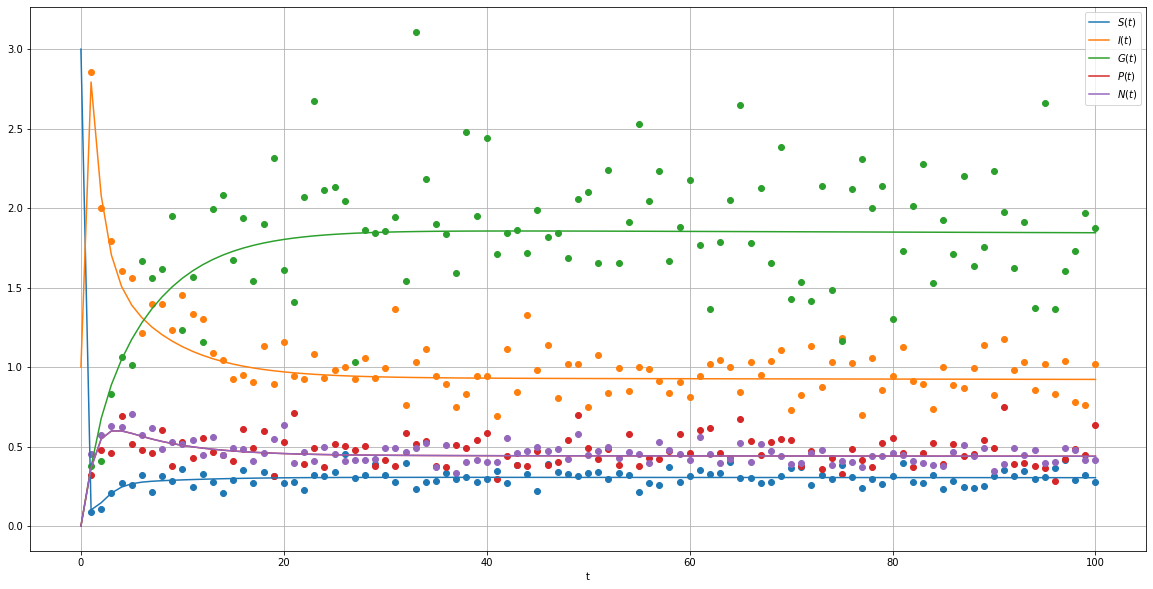

In [9]:
# Observational model
np.random.seed(123)

obs = np.random.lognormal(
    mean=np.log(sol[1::]), 
    sigma=np.random.uniform(0.1, 0.3, size=sol.shape[1])
)
    
model.plot(sol, "male", "high", "(25, 50)", obs=obs)

In [15]:
args = flatten_params(*(
    tfd.Dirichlet(np.ones((len(S_CATEGORIES),))).sample(),               # sip
    tfd.Beta(3, 2).sample(len(G_CATEGORIES)),                            # beta
    generate_social_interaction_matrix(),                                # c
    tfd.Exponential(1/2).sample(len(G_CATEGORIES)),                      # di
    tfd.Exponential(1/7).sample(len(G_CATEGORIES)),                      # wip
    tfd.Exponential(1/3).sample(len(G_CATEGORIES)),                      # dai
    tfd.Exponential(1/14).sample(len(G_CATEGORIES)),                     # dwt
    tfd.Dirichlet(np.ones((len(G_CATEGORIES),))).sample(),               # psc
    np.array([1825.]),                                                   # r
), framework=np).astype(np.float32)

def func(t, y):
    return tf.Variable(system(y, t, args, tf))

results = tfp.math.ode.BDF().solve(func, 0, state0, solution_times=t[:2])

Variational Inference (VI) methods are used to identify complex distributions as an alternative to the computationally costly (but very accurate) Markov chain Monte Carlo (MCMC) sampling. In general, MCMC provide guarantees of producing (asymptotically) exact samples from the target density [4, p.3]. In VI case, we use a less complex but still flexible **family** of distributions to approximate an intractable distribution. Some literature works on VI are

1. Information Theory, Inference and Learning Algorithms, David J. C. MacKay, David J. C. Mac Kay, Cambridge University Press, 2003
2. Bayesian Reasoning and Machine Learning, David Barber, Cambridge University Press, 2012
3. Pattern Recognition and Machine Learning, Christopher M. Bishop, Springer New York, 2016
4. Variational Inference: A Review for Statisticians, David M. Blei, Alp Kucukelbir, Jon D. McAuliffe, 2018
5. High-Level Explanation of Variational Inference, Jason Eisner, 2011

For business and academic projects, where Bayesian models are fitted on very large datasets (Big Data applications), approximate inference methods are a very efficient and optimised way of infering quite accurate results.


Assume that we want to use VI on a Bayesian regression, let $x$ be the independent variables with $X$ their matrix form and $y$ the continuous responce variable. The coefficients $\beta$ of the model follow a complex multimodal distribution. 

$$
y = \mathcal{N}(\beta^{T}X, \sigma^{2})
$$

in Bayesian form, we want to infer the posterior of the model, in other words the distribution of the coefficients

$$
p(\beta|y, X) = \frac{p(y|X, \beta)p(\beta|X)}{p(y)}
$$

The complexity of the posterior distribution means that we have two ways to compute the results

1. Use MCMC sampling methods (Gibb's, Hamiltonian)
2. Use approximate methods

To use approximate inference we follow the steps, that are similar to [1, 2, 4]

$$
\begin{aligned}
KL(q(\beta)||p(\beta|y, X)) &= \int q(\beta) \log\bigg(\frac{q(\beta)}{p(\beta|y, X)}\bigg) d\beta \\
&= \int q(\beta) \log(q(\beta)) d\beta - \int q(\beta) \log(p(\beta|y, X)) d\beta \\
&= \int q(\beta) \log(q(\beta)) d\beta - \int q(\beta) \log\bigg(\frac{p(y|\beta, X)p(\beta|X)}{p(y)}\bigg)d\beta \\
&= \int q(\beta) \log(q(\beta))d\beta - \int q(\beta) \log(p(y|\beta, X)p(\beta|X))d\beta + \log(p(y)) \\
&= \int q(\beta) \log(q(\beta))d\beta - \int q(\beta) \log(p(\beta|X))d\beta - \int q(\beta) \log(p(y|\beta, X))d\beta + \log(p(y)) \\
&= \int q(\beta) \log\bigg(\frac{q(\beta)}{p(\beta|X)}\bigg)d\beta - \int q(\beta) \log(p(y|\beta, X))d\beta + \log(p(y)) \\
&= KL(q(\beta)||p(\beta|X)) - \mathbb{E}_{q}(\log(p(y|\beta, X))) + \log(p(y))
\end{aligned}
$$

the RHS of the equation shows the entropy, the average energy and the evidence (marginal of $y$).
By setting the lower bound (and change the signs because we move the $\log(p(y))$ on the LHS) as

$$
ELBO(q) = \mathbb{E}_{q}(\log(p(y|\beta, X))) - KL(q(\beta)||p(\beta|X))
$$

and the previous formula becomes

$$
\log(p(y)) = ELBO(q) + KL(q(\beta)||p(\beta|y, X))
$$

which is similar to the formula that Bishop has in his book [3, p.463]

In [12]:
# sigma = tfd.HalfCauchy(
#     1, scale=1, name='HalfCauchy'
# )

In [13]:
# scale_HC = tf.dtypes.cast(sigma.sample(state0.shape[0]), tf.float32)
# score = tf.dtypes.cast(results[3][0][0], tf.float32)

In [14]:
# tfd.Dirichlet(np.ones((len(S_CATEGORIES),))).sample(),               # sip
#     tfd.Beta(3, 2).sample(len(G_CATEGORIES)),                            # beta
#     generate_social_interaction_matrix(),                                # c
#     tfd.Exponential(1/2).sample(len(G_CATEGORIES)),                      # di
#     tfd.Exponential(1/7).sample(len(G_CATEGORIES)),                      # wip
#     tfd.Exponential(1/3).sample(len(G_CATEGORIES)),                      # dai
#     tfd.Exponential(1/14).sample(len(G_CATEGORIES)),                     # dwt
#     tfd.Dirichlet(np.ones((len(G_CATEGORIES),))).sample(),               # psc
#     1825.,              

In [39]:
results.states[0]

<tf.Tensor: shape=(80,), dtype=float32, numpy=
array([3., 3., 5., 4., 3., 3., 4., 3., 2., 3., 1., 2., 2., 1., 7., 4., 0.,
       1., 2., 4., 5., 3., 2., 2., 7., 3., 3., 2., 3., 4., 6., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [19]:
Root = tfd.JointDistributionCoroutine.Root
def model_fn():
    sip = yield Root(tfd.Dirichlet(np.ones((len(S_CATEGORIES),), dtype=np.float32), name="sip"))
    beta = yield Root(tfd.Sample(tfd.Beta(3, 2, name="beta"), sample_shape=(len(G_CATEGORIES),)))
    di = yield Root(tfd.Sample(tfd.Exponential(1/2, name="di"), sample_shape=(len(G_CATEGORIES),)))
    wip = yield Root(tfd.Sample(tfd.Exponential(1/7, name="wip"), sample_shape=(len(G_CATEGORIES),)))
    dai = yield Root(tfd.Sample(tfd.Exponential(1/3, name="dai"), sample_shape=(len(G_CATEGORIES),)))
    dwt = yield Root(tfd.Sample(tfd.Exponential(1/14, name="dwt"), sample_shape=(len(G_CATEGORIES),)))
    psc = yield Root(tfd.Dirichlet(np.ones((len(G_CATEGORIES),), dtype=np.float32), name="psc"))
    
    args_ = flatten_params(*(
        sip, 
        beta, 
        tf.constant(generate_social_interaction_matrix(), dtype=tf.float32),
        di, 
        wip, 
        dai, 
        dwt, 
        psc, 
        tf.constant(np.array([1825.]), dtype=tf.float32)
    ), framework=tf)
    
    def f(t, y):
        return system(y, t, args_, tf)
    bijector = tfb.FFJORD(
        f, 
        tfp.math.ode.BDF().solve, 
        trace_augmentation_fn=tfb.ffjord.trace_jacobian_exact, 
        dtype=tf.float32
    )
    y = bijector.forward(results.states[0])
    x = bijector.inverse(results.states[-1])
    base = tfd.Gamma(tf.ones_like(x) * 5., tf.ones_like(x))
    out = yield tfd.TransformedDistribution(base, bijector)
    
model = tfd.JointDistributionCoroutine(model_fn)

In [20]:
q_sip_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_sip_loc')
q_sip_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_sip_scale')
q_beta_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_beta_loc')
q_beta_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_beta_scale')
q_di_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_di_loc')
q_di_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_di_scale')
q_wip_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_wip_loc')
q_wip_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_wip_scale')
q_dai_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_dai_loc')
q_dai_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_dai_scale')
q_dwt_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_dwt_loc')
q_dwt_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_dwt_scale')
q_psc_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_psc_loc')
q_psc_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_psc_scale')

def variational_model_fn():
    sip = yield Root(tfd.Normal(loc=q_sip_loc, scale=tf.nn.softplus(q_sip_scale)))
    beta = yield Root(tfd.Normal(loc=q_beta_loc, scale=tf.nn.softplus(q_beta_scale)))
    di = yield Root(tfd.Normal(loc=q_di_loc, scale=tf.nn.softplus(q_di_scale)))
    wip = yield Root(tfd.Normal(loc=q_wip_loc, scale=tf.nn.softplus(q_wip_scale)))
    dai = yield Root(tfd.Normal(loc=q_dai_loc, scale=tf.nn.softplus(q_dai_scale)))
    dwt = yield Root(tfd.Normal(loc=q_dwt_loc, scale=tf.nn.softplus(q_dwt_scale)))
    psc = yield Root(tfd.Normal(loc=q_psc_loc, scale=tf.nn.softplus(q_psc_scale)))
    
    args_ = flatten_params(*(
        sip, 
        beta, 
        tf.constant(generate_social_interaction_matrix(), dtype=tf.float32),
        di, 
        wip, 
        dai, 
        dwt, 
        psc, 
        tf.constant(np.array([1825.]), dtype=tf.float32)
    ), framework=tf)
    
    y = yield tfd.VectorDeterministic(args_)
q = tfd.JointDistributionCoroutine(variational_model_fn)

### !!! TODO: FIXME !!!!

In [17]:
# Copyright 2018 The TensorFlow Probability Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""Utility function to construct the diagonal of a Jacobian matrix."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow.compat.v2 as tf

from tensorflow_probability.python.math.gradient import value_and_gradient


def diag_jacobian2(xs,
                  ys=None,
                  sample_shape=None,
                  fn=None,
                  parallel_iterations=10,
                  name=None):

    with tf.name_scope(name or 'jacobians_diag'):
        if sample_shape is None:
            sample_shape = [1]
        # Output Jacobian diagonal
        jacobians_diag_res = []
        # Convert input `xs` to a list
        xs = list(xs) if _is_list_like(xs) else [xs]
        xs = [tf.convert_to_tensor(x) for x in xs]
        if not tf.executing_eagerly():
            if ys is None:
                if fn is None:
                    raise ValueError('Both `ys` and `fn` can not be `None`')
                else:
                    ys = fn(*xs)
            # Convert ys to a list
            raise ValueError(ys)
            ys = list(ys) if _is_list_like(ys) else [ys]
            if len(xs) != len(ys):
                raise ValueError('`xs` and `ys` should have the same length')
            for y, x in zip(ys, xs):
                # Broadcast `y` to the shape of `x`.
                y_ = y + tf.zeros_like(x)
                # Change `event_shape` to one-dimension
                y_ = tf.reshape(y, tf.concat([sample_shape, [-1]], -1))

                # Declare an iterator and tensor array loop variables for the gradients.
                n = tf.size(x) / tf.cast(tf.reduce_prod(sample_shape), dtype=tf.int32)
                n = tf.cast(n, dtype=tf.int32)
                loop_vars = [
                    0,
                    tf.TensorArray(x.dtype, n)
                ]

                def loop_body(j):
                    """Loop function to compute gradients of the each direction."""
                    # Gradient along direction `j`.
                    res = tf.gradients(ys=y_[..., j], xs=x)[0]  # pylint: disable=cell-var-from-loop
                    if res is None:
                    # Return zero, if the gradient is `None`.
                        res = tf.zeros(tf.concat([sample_shape, [1]], -1),
                           dtype=x.dtype)  # pylint: disable=cell-var-from-loop
                    else:
                        # Reshape `event_shape` to 1D
                        res = tf.reshape(res, tf.concat([sample_shape, [-1]], -1))
                        # Add artificial dimension for the case of zero shape input tensor
                        res = res[tf.newaxis, ..., j]
                    return res  # pylint: disable=cell-var-from-loop

            # Iterate over all elements of the gradient and compute second order
            # derivatives.
            _, jacobian_diag_res = tf.while_loop(
                cond=lambda j, _: j < n,  # pylint: disable=cell-var-from-loop
                body=lambda j, result: (j + 1, result.write(j, loop_body(j))),
                loop_vars=loop_vars,
                parallel_iterations=parallel_iterations)

            shape_x = tf.shape(x)
            # Stack gradients together and move flattened `event_shape` to the
            # zero position
            reshaped_jacobian_diag = tf.transpose(a=jacobian_diag_res.stack())
            # Reshape to the original tensor
            reshaped_jacobian_diag = tf.reshape(reshaped_jacobian_diag, shape_x)
            jacobians_diag_res.append(reshaped_jacobian_diag)

        else:
            if fn is None:
                raise ValueError('`fn` can not be `None` when eager execution is '
                         'enabled')
            if ys is None:
                ys = fn(*xs)

            def fn_slice(i, j):
                """Broadcast y[i], flatten event shape of y[i], return y[i][..., j]."""
                def fn_broadcast(*state):
                    res = fn(*state)
                    res = list(res) if _is_list_like(res) else [res]
                    if len(res) != len(state):
                        res *= len(state)
                        res = [tf.reshape(r + tf.zeros_like(s),
                            tf.concat([sample_shape, [-1]], -1))
                        for r, s in zip(res, state)]
                    return res
                # Expand dimensions before returning in order to support 0D input `xs`
                return lambda *state: tf.expand_dims(fn_broadcast(*state)[i], 0)[..., j]

            def make_loop_body(i, x):
                """Loop function to compute gradients of the each direction."""
                def _fn(j, result):
                    res = value_and_gradient(fn_slice(i, j), xs)[1][i]
                    if res is None:
                        res = tf.zeros(sample_shape, dtype=x.dtype)
                    else:
                        res = tf.reshape(res, tf.concat([sample_shape, [-1]], -1))
                        res = res[..., j]
                    return j + 1, result.write(j, res)
                return _fn

            for i, x in enumerate(xs):
                # Declare an iterator and tensor array loop variables for the gradients.
                n = tf.size(x) / tf.cast(tf.reduce_prod(sample_shape), dtype=tf.int32)
                n = tf.cast(n, dtype=tf.int32)
                loop_vars = (0, tf.TensorArray(x.dtype, n, element_shape=sample_shape))

                # Iterate over all elements of the gradient and compute second order
                # derivatives.
                _, jacobian_diag_res = tf.while_loop(
                    cond=lambda j, _: j < n,
                    body=make_loop_body(i, x),
                    loop_vars=loop_vars,
                    parallel_iterations=parallel_iterations)

                shape_x = tf.shape(x)
                # Stack gradients together and move flattened `event_shape` to the
                # zero position
                reshaped_jacobian_diag = tf.transpose(a=jacobian_diag_res.stack())
                # Reshape to the original tensor
                reshaped_jacobian_diag = tf.reshape(reshaped_jacobian_diag, shape_x)
                jacobians_diag_res.append(reshaped_jacobian_diag)

    return ys, jacobians_diag_res


def _is_list_like(x):
    """Helper which returns `True` if input is `list`-like."""
    return isinstance(x, (tuple, list))

tfb.ffjord.tfp_math.diag_jacobian = diag_jacobian2

In [21]:
losses = tfp.vi.fit_surrogate_posterior(
  target_log_prob_fn=lambda *args: model.log_prob(args),
  surrogate_posterior=q,
  optimizer=tf.optimizers.Adam(learning_rate=0.1),
  sample_size=1,
  num_steps=500
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


FailedPreconditionError: Error while reading resource variable monte_carlo_variational_loss/expectation/monte_carlo_variational_loss_expectation_ffjord/forward/bdf/jacobians_diag/Variable_4233713 from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/monte_carlo_variational_loss/expectation/monte_carlo_variational_loss_expectation_ffjord/forward/bdf/jacobians_diag/Variable_4233713/N10tensorflow3VarE does not exist. [Op:ReadVariableOp]

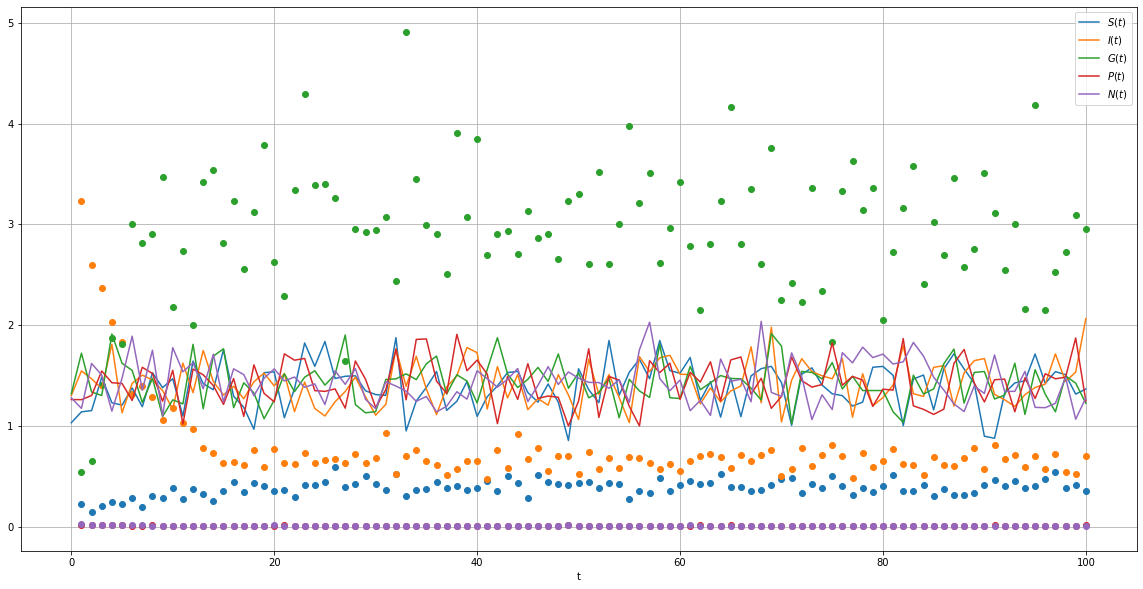

In [36]:
model.plot(
    q.sample(101), 
    "male", 
    "high", 
    "(25, 50)", 
    obs=obs
)

## Example

In [38]:
# Toy 1D data.
index_points = np.array([-10., -7.2, -4., -0.1, 0.1, 4., 6.2, 9.]).reshape(
    [-1, 1]).astype(np.float32)
observed_counts = np.array(
    [100, 90, 60, 13, 18, 37, 55, 42]).astype(np.float32)

# Trainable GP hyperparameters.
kernel_log_amplitude = tf.Variable(0., name='kernel_log_amplitude')
kernel_log_lengthscale = tf.Variable(0., name='kernel_log_lengthscale')
observation_noise_log_scale = tf.Variable(
  0., name='observation_noise_log_scale')

# Generative model.
Root = tfd.JointDistributionCoroutine.Root
def model_fn():
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.exp(kernel_log_amplitude),
      length_scale=tf.exp(kernel_log_lengthscale))
    latent_log_rates = yield Root(tfd.GaussianProcess(
      kernel,
      index_points=index_points,
      observation_noise_variance=tf.exp(observation_noise_log_scale),
      name='latent_log_rates'))
    y = yield tfd.Independent(tfd.Poisson(log_rate=latent_log_rates, name='y'),
                            reinterpreted_batch_ndims=1)
model = tfd.JointDistributionCoroutine(model_fn)

In [39]:
logit_locs = tf.Variable(tf.zeros(observed_counts.shape), name='logit_locs')
logit_softplus_scales = tf.Variable(tf.ones(observed_counts.shape) * -4,
                                    name='logit_softplus_scales')
def variational_model_fn():
    latent_rates = yield Root(tfd.Independent(
    tfd.Normal(loc=logit_locs, scale=tf.nn.softplus(logit_softplus_scales)),
    reinterpreted_batch_ndims=1))
    y = yield tfd.VectorDeterministic(latent_rates)
q = tfd.JointDistributionCoroutine(variational_model_fn)

In [40]:
losses, log_amplitude_path, sample_path = tfp.vi.fit_surrogate_posterior(
  target_log_prob_fn=lambda *args: model.log_prob(args),
  surrogate_posterior=q,
  optimizer=tf.optimizers.Adam(learning_rate=0.1),
  sample_size=1,
  num_steps=500,
  trace_fn=lambda loss, grads, vars: (loss, kernel_log_amplitude,
                                      q.sample(5, seed=42)[0]))

In [41]:
model.sample(), q.sample()

((<tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-2.3941154 , -0.09614992,  0.771525  , -1.4176776 ,  0.32875705,
          0.893997  , -1.5008167 , -0.5344367 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 4., 0., 0., 3., 0., 0.], dtype=float32)>),
 (<tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-6.0753107 , -6.1401367 , -0.53637695, -1.7946572 , -2.9305344 ,
         -3.530294  , -3.1744535 , -2.0744176 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-6.0753107 , -6.1401367 , -0.53637695, -1.7946572 , -2.9305344 ,
         -3.530294  , -3.1744535 , -2.0744176 ], dtype=float32)>))